"""
# Proyecto MLOps: Modelo predictivo de ventas - Evaluación de para tienda Minorista

Este proyecto forma parte de una pipeline de desarrollo y despliegue de modelos de machine learning en entornos productivos. El objetivo es construir un modelo robusto capaz de predecir el total de ventas mensuales de una tienda minorista, a partir de datos históricos diarios.

El sistema se integrará en una arquitectura MLOps donde los artefactos del modelo, la trazabilidad de experimentos, y las métricas estarán disponibles para auditoría y versionado.

-------------------------------------------------------------------------------
🔧 FASES DEL DESARROLLO DEL MODELO

## 1. Ingesta y Preparación de Datos
- Fuente: CSV / base de datos.
- Procesos:
    - Validación de esquema y tipos de datos.
    - Imputación de valores faltantes.
    - Codificación de variables categóricas si aplica.
    - División en conjuntos de entrenamiento, validación y test.

## 2. Análisis Exploratorio de Datos (EDA)
- Análisis visual y estadístico de distribución de ventas.
- Evaluación de correlaciones entre variables predictoras y objetivo.
- Agrupamientos temporales: comparativas entre días hábiles, festivos y fines de semana.
- Identificación de outliers o patrones estacionales.

## 3. Entrenamiento de Modelos Base
- Modelos evaluados:
    - `LinearRegression()`
    - `DecisionTreeRegressor()`
    - `RandomForestRegressor()`
    - *(opcional: agregar Lasso, XGBoost, etc.)*
- Métricas:
    - Coeficiente de determinación: R²
    - Error cuadrático medio (RMSE)
    - Error absoluto medio (MAE)
- Técnicas:
    - Búsqueda de hiperparámetros (`GridSearchCV` / `RandomizedSearchCV`)
    - Validación cruzada (`cross_val_score`)

## 4. Evaluación y Visualización
- Generación de reportes con métricas para cada modelo.
- Gráficos de comparación: ventas reales vs predichas.
- Análisis de errores por categoría y por horizonte temporal.

## 5. Empaquetado del Modelo
- Serialización del mejor modelo (`joblib` o `pickle`).
- Exportación de métricas y visualizaciones.
- Generación de archivo `requirements.txt` y documentación del entorno virtual.

## 6. Preparación para Producción (MLOps)
- Scripts de inferencia reutilizables (`predict.py`)
- Interfaz REST o CLI para consultas.
- Documentación técnica y funcional en README.md
- (Opcional) Integración con `MLflow` para seguimiento de experimentos.
- (Opcional) Despliegue en contenedor Docker / pipeline CI/CD.

-------------------------------------------------------------------------------
🎯 OBJETIVO DEL MODELO
Predecir el total de ventas para el mes siguiente en función de variables históricas,
lo que permitirá a la tienda:
- Optimizar su inventario.
- Definir estrategias promocionales.
- Asignar personal de forma eficiente.

-------------------------------------------------------------------------------
🧾 NOTAS ADICIONALES
- Enfocado en reproducibilidad, modularidad y trazabilidad.
- Compatible con flujos de trabajo de ciencia de datos y arquitectura MLOps.
- Código limpio, comentado y preparado para pruebas automatizadas.

"""


## 1. Preparación de datos

In [1]:
# Importar librerías
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
# Datos de la tienda minorista
ruta = "./Datos/Ventas.csv"

# Cargar el dataset
df = pd.read_csv(ruta)
df.head()

,Fecha,DíaDeLaSemana,Promociones,Festivo,Ventas
0,2022-01-01,6,0,0,4033
1,2022-01-02,7,0,1,4012
2,2022-01-03,1,0,0,1608
3,2022-01-04,2,1,0,2046
4,2022-01-05,3,0,0,2484


In [3]:
# Comprobar si hay valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fecha          365 non-null    object
 1   DíaDeLaSemana  365 non-null    int64 
 2   Promociones    365 non-null    int64 
 3   Festivo        365 non-null    int64 
 4   Ventas         365 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.4+ KB


In [4]:
# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.head()

,Fecha,DíaDeLaSemana,Promociones,Festivo,Ventas
0,2022-01-01,6,0,0,4033
1,2022-01-02,7,0,1,4012
2,2022-01-03,1,0,0,1608
3,2022-01-04,2,1,0,2046
4,2022-01-05,3,0,0,2484


In [5]:
escala = MinMaxScaler(feature_range=(0, 1))

# Eliminamos las columnas no deseadas y guardamos los nombres de las columnas que vamos a escalar
columnas_para_escalar = df.drop(["Ventas", "Fecha"], axis=1).columns

# Ajustamos el MinMaxScaler a las columnas restantes y transformamos los datos
normado = escala.fit_transform(df[columnas_para_escalar])

# Creamos un nuevo DataFrame con los datos normalizados y las columnas correctas
df_normado = pd.DataFrame(data=normado, columns=columnas_para_escalar)

# Si necesitas, puedes agregar las columnas no escaladas que has quitado previamente
df_normado["Ventas"] = df["Ventas"]
df_normado["Fecha"] = df["Fecha"]

# Ahora df_normado tiene los datos normalizados y las columnas no normalizadas originales
df_normado.head()

,DíaDeLaSemana,Promociones,Festivo,Ventas,Fecha
0,0.833333,0.0,0.0,4033,2022-01-01
1,1.000000,0.0,1.0,4012,2022-01-02
2,0.000000,0.0,0.0,1608,2022-01-03
3,0.166667,1.0,0.0,2046,2022-01-04
4,0.333333,0.0,0.0,2484,2022-01-05


In [6]:
# Comprobación del tipo de dato de Fecha
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          365 non-null    datetime64[ns]
 1   DíaDeLaSemana  365 non-null    int64         
 2   Promociones    365 non-null    int64         
 3   Festivo        365 non-null    int64         
 4   Ventas         365 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 14.4 KB


In [7]:
# Identificar las variables dependientes e independientes
X = df_normado.drop(['Ventas', 'Fecha'], axis=1)
y = df['Ventas']

In [8]:
# Dividir en conjuntos de entrenamiento y prueba
X_entrena, X_prueba, y_entrena, y_prueba = train_test_split(X, y, train_size=0.8, random_state=42)

## 2. Análisis Exploratorio de Datos (EDA)

In [9]:
# Estadísticas descriptivas
df.describe()

,Fecha,DíaDeLaSemana,Promociones,Festivo,Ventas
count,365,365.000000,365.000000,365.000000,365.000000
mean,2022-07-01 23:59:59.999999744,4.005479,0.200000,0.142466,2997.219178
min,2022-01-01 00:00:00,1.000000,0.000000,0.000000,1305.000000
25%,2022-04-02 00:00:00,2.000000,0.000000,0.000000,2195.000000
50%,2022-07-02 00:00:00,4.000000,0.000000,0.000000,3074.000000
75%,2022-10-01 00:00:00,6.000000,0.000000,0.000000,3979.000000
max,2022-12-31 00:00:00,7.000000,1.000000,1.000000,4404.000000
std,NaN,2.002738,0.400549,0.350007,942.096284


''

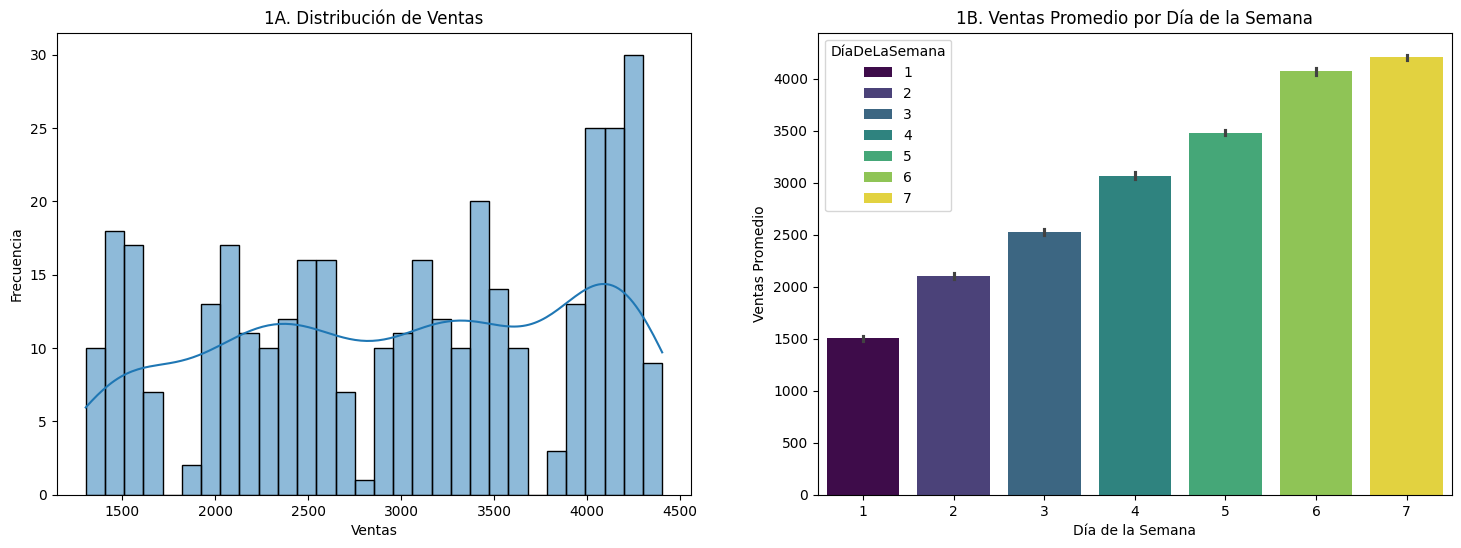

In [10]:
fig1, axes1 = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(df['Ventas'], bins=30, kde=True, ax=axes1[0])
axes1[0].set_title('1A. Distribución de Ventas')
axes1[0].set_xlabel('Ventas')
axes1[0].set_ylabel('Frecuencia')

sns.barplot(data=df, x='DíaDeLaSemana', y='Ventas', hue='DíaDeLaSemana', palette='viridis', ax=axes1[1])
axes1[1].set_title('1B. Ventas Promedio por Día de la Semana')
axes1[1].set_xlabel('Día de la Semana')
axes1[1].set_ylabel('Ventas Promedio')
;

''

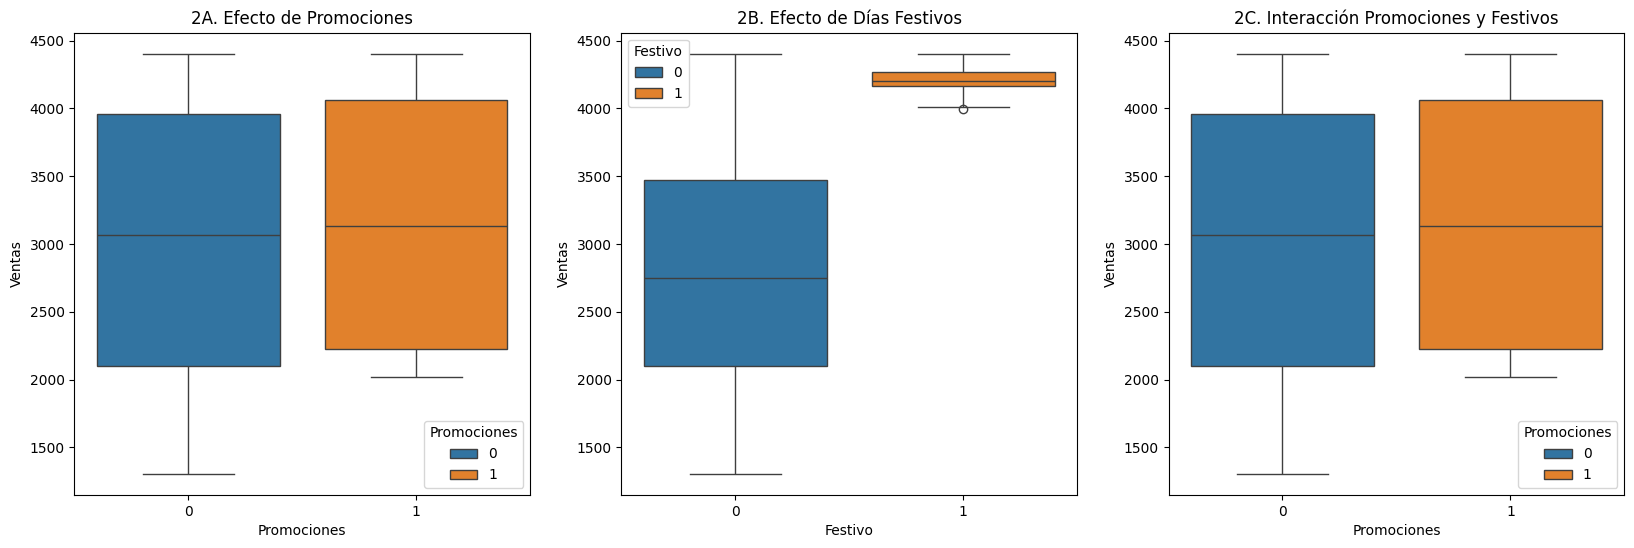

In [11]:
# boxplot para comparar las ventas con y sin promociones.
fig2, axes2 = plt.subplots(1, 3, figsize=(20, 6))

sns.boxplot(x='Promociones', y='Ventas', data=df, ax=axes2[0], hue='Promociones')
axes2[0].set_title('2A. Efecto de Promociones')

sns.boxplot(x='Festivo', y='Ventas', data=df, ax=axes2[1], hue='Festivo')
axes2[1].set_title('2B. Efecto de Días Festivos')

sns.boxplot(x='Promociones', y='Ventas', data=df, hue='Promociones', ax=axes2[2])
axes2[2].set_title('2C. Interacción Promociones y Festivos')
;

## 3. Selección de modelo

In [12]:
# almacenar modelos
modelos = [
    ("modelo lineal", LinearRegression()),
    ("modelo arbol", DecisionTreeRegressor(random_state=42)),
    ("modelo bosque", RandomForestRegressor(random_state=42))
]

In [13]:
for nombre, modelo in modelos:
    modelo.fit(X_entrena, y_entrena)
    pred = modelo.predict(X_prueba)
    r2 = r2_score(y_prueba, pred)
    rmse = np.sqrt(mean_squared_error(y_prueba, pred))  # corregido
    print(f'{nombre}: R² = {r2:.3f}, RMSE = {rmse:.2f}')


modelo lineal: R² = 0.992, RMSE = 86.24
modelo arbol: R² = 0.992, RMSE = 86.66
modelo bosque: R² = 0.992, RMSE = 86.89


## 4. Entrenamiento y evaluación del modelo

In [14]:
# Alojamos el modelo de Regresión Lineal en una variable
modelo_lineal = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento
modelo_lineal.fit(X_entrena, y_entrena)

# Realizamos predicciones usando el conjunto de prueba
predicciones_lineal = modelo_lineal.predict(X_prueba)

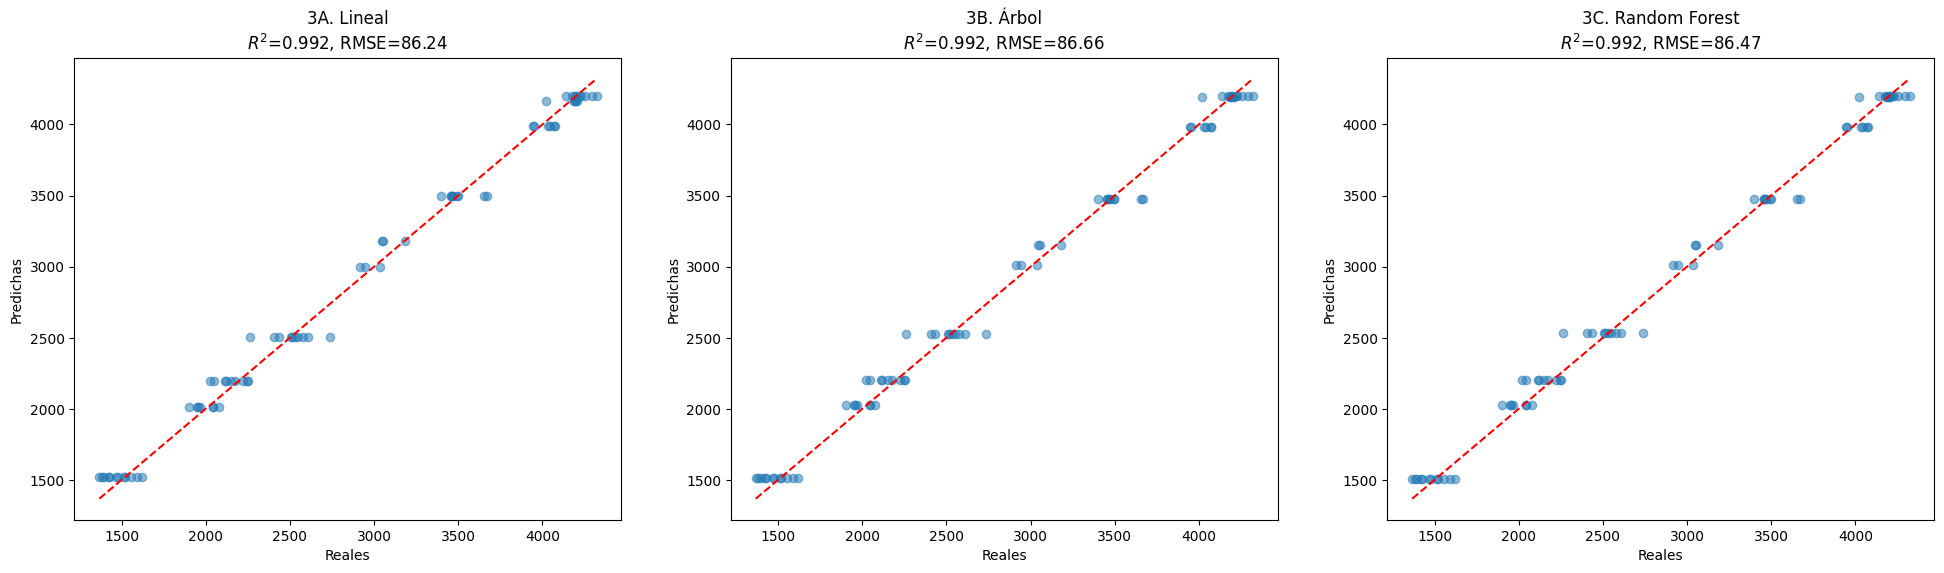

In [15]:
# Alojamos el modelo de Regresión Lineal en una variable
modelo_lineal = LinearRegression().fit(X_entrena, y_entrena)
modelo_arbol = DecisionTreeRegressor().fit(X_entrena, y_entrena)
modelo_rf = RandomForestRegressor().fit(X_entrena, y_entrena)

pred_lineal = modelo_lineal.predict(X_prueba)
pred_arbol = modelo_arbol.predict(X_prueba)
pred_rf = modelo_rf.predict(X_prueba)

r2_l, rmse_l = r2_score(y_prueba, pred_lineal), np.sqrt(mean_squared_error(y_prueba, pred_lineal))
r2_a, rmse_a = r2_score(y_prueba, pred_arbol), np.sqrt(mean_squared_error(y_prueba, pred_arbol))
r2_rf, rmse_rf = r2_score(y_prueba, pred_rf), np.sqrt(mean_squared_error(y_prueba, pred_rf))

fig3, axes3 = plt.subplots(1, 3, figsize=(24, 6))

axes3[0].scatter(y_prueba, pred_lineal, alpha=0.5)
axes3[0].plot([y_prueba.min(), y_prueba.max()], [y_prueba.min(), y_prueba.max()], 'r--')
axes3[0].set_title(f'3A. Lineal\n$R^2$={r2_l:.3f}, RMSE={rmse_l:.2f}')
axes3[0].set_xlabel('Reales')
axes3[0].set_ylabel('Predichas')

axes3[1].scatter(y_prueba, pred_arbol, alpha=0.5)
axes3[1].plot([y_prueba.min(), y_prueba.max()], [y_prueba.min(), y_prueba.max()], 'r--')
axes3[1].set_title(f'3B. Árbol\n$R^2$={r2_a:.3f}, RMSE={rmse_a:.2f}')
axes3[1].set_xlabel('Reales')
axes3[1].set_ylabel('Predichas')

axes3[2].scatter(y_prueba, pred_rf, alpha=0.5)
axes3[2].plot([y_prueba.min(), y_prueba.max()], [y_prueba.min(), y_prueba.max()], 'r--')
axes3[2].set_title(f'3C. Random Forest\n$R^2$={r2_rf:.3f}, RMSE={rmse_rf:.2f}')
axes3[2].set_xlabel('Reales')
axes3[2].set_ylabel('Predichas');




''

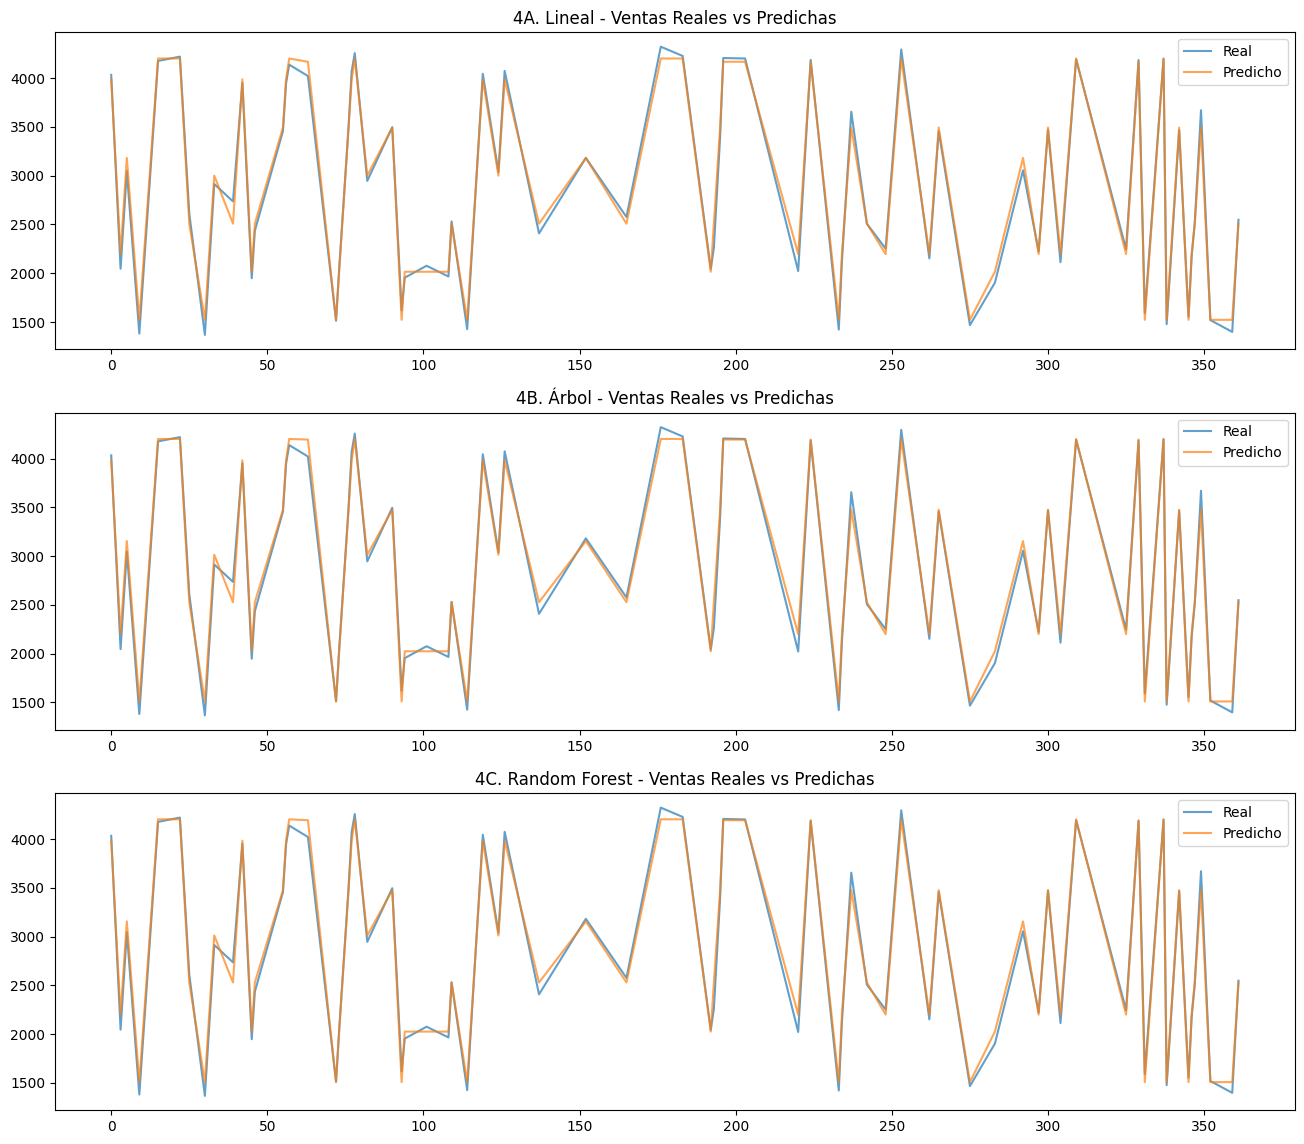

In [16]:
df_lineal = pd.DataFrame({'Real': y_prueba, 'Predicho': pred_lineal}).sort_index()
df_arbol = pd.DataFrame({'Real': y_prueba, 'Predicho': pred_arbol}).sort_index()
df_rf = pd.DataFrame({'Real': y_prueba, 'Predicho': pred_rf}).sort_index()

fig4, axes4 = plt.subplots(3, 1, figsize=(16, 14))

axes4[0].plot(df_lineal['Real'], label='Real', alpha=0.7)
axes4[0].plot(df_lineal['Predicho'], label='Predicho', alpha=0.7)
axes4[0].legend()
axes4[0].set_title('4A. Lineal - Ventas Reales vs Predichas')

axes4[1].plot(df_arbol['Real'], label='Real', alpha=0.7)
axes4[1].plot(df_arbol['Predicho'], label='Predicho', alpha=0.7)
axes4[1].legend()
axes4[1].set_title('4B. Árbol - Ventas Reales vs Predichas')

axes4[2].plot(df_rf['Real'], label='Real', alpha=0.7)
axes4[2].plot(df_rf['Predicho'], label='Predicho', alpha=0.7)
axes4[2].legend()
axes4[2].set_title('4C. Random Forest - Ventas Reales vs Predichas');
;

## 5. Conclusión

1. El primer gráfico, que muestra un diagrama de dispersión de las Ventas Reales vs Ventas Predichas, sugiere que el modelo de regresión lineal está haciendo un buen trabajo al predecir las ventas. La línea de tendencia indica una fuerte relación positiva entre los valores reales y predichos, lo que es un signo prometedor de que el modelo puede capturar la tendencia de las ventas con eficacia.
2. El segundo gráfico compara las Ventas Reales y las Ventas Predichas a lo largo del tiempo y también parece seguir un patrón similar, aunque hay algunos puntos en los que las predicciones y los valores reales difieren significativamente. Esto puede deberse a eventos no capturados por las variables en tu modelo o a variaciones naturales en las ventas que no son predecibles.

Aquí hay algunas recomendaciones para la tienda minorista:
* Optimización de Inventario: Utiliza las predicciones para gestionar mejor el inventario. Las fechas festivas pueden requerir un stock adicional para evitar la falta de productos.
* Planificación de Personal: Ajusta los horarios del personal según días festivos, y no necesariamente según dias de promociones. 
* Marketing Dirigido: Si identificas patrones de cuándo las ventas son más fuertes, puedes dirigir las campañas de marketing para esos periodos y potencialmente aumentar aún más las ventas.
* Análisis de Anomalías: Investiga aquellos puntos donde hay grandes desviaciones entre las ventas reales y las predichas para entender mejor los factores no capturados por el modelo.
* Mejoras en el Modelo: Considera incluir más variables en el modelo que puedan afectar las ventas, como datos económicos generales, eventos locales, competencia, o incluso el clima.


In [17]:
# Asegurar que el directorio exista
os.makedirs("Salidas", exist_ok=True)

fig1.tight_layout()
fig1.savefig("Salidas/1_distribucion_y_dias.png", dpi=300)

fig2.tight_layout()
fig2.savefig("Salidas/2_boxplots_comparativos.png", dpi=300)

fig3.tight_layout()
fig3.savefig("Salidas/3_pred_vs_real_modelos.png", dpi=300)

fig4.tight_layout()
fig4.savefig("Salidas/4_comparacion_temporal_modelos.png", dpi=300)

print("✅ Figuras guardadas en carpeta 'Salidas/'")



✅ Figuras guardadas en carpeta 'Salidas/'
